In [1]:
import collections
import itertools
import json
import os
import re
import glob
import operator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [2]:
def compute_accuracy(rows):
    levels = ['easy', 'medium', 'hard', 'extra', 'all']
    total = collections.defaultdict(int)
    exact = collections.defaultdict(int)
    for row in rows:
        exact[row['hardness']] += row['exact']
        exact['all'] += row['exact']
        total[row['hardness']] += 1
        total['all'] += 1
    
    result = {hardness: exact[hardness] / total[hardness]
              for hardness in levels}
    result = {**result, **{'{} count'.format(hardness): total[hardness] for hardness in levels}}
    return result

In [27]:
accuracy_per_run = collections.defaultdict(dict)
rows = []
for d in sorted(glob.glob('../logdirs/20190428-random/*')):
    exp_name = os.path.basename(d)
    fixed, att = re.match('fixed=([^,]+),att=(\d+)', exp_name).groups()

    eval_paths = glob.glob(os.path.join(d, 'eval-val-step*-bs1.jsonl'))
    all_scores = []
    best = (0, 0)
    for eval_path in eval_paths:
        step = int(re.search('step(\d+)', eval_path).group(1))
        scores = json.load(open(eval_path))
        first_half_exact = compute_accuracy(scores['per_item'][:517])
        second_half_exact = compute_accuracy(scores['per_item'][517:])
        all_scores.append((step, scores['total_scores']['all']['exact'], first_half_exact['all'], second_half_exact['all']))
    
    all_scores.sort(key=operator.itemgetter(0))
    sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
    rows.append((fixed, att, len(eval_paths)) + (sorted_scores[0] if sorted_scores else (-1, -1, -1, -1)))
    accuracy_per_run[exp_name] = {
        'x': [s[0] for s in all_scores],
        'all': [s[1] for s in all_scores],
        '1/2': [s[2] for s in all_scores],
        '2/2': [s[3] for s in all_scores],
    }
    print(d)
    
df = pd.DataFrame(rows, columns=('fixed', 'att', 'num steps eval', 'step', 'acc', '1/2 acc', '2/2 acc'))

../logdirs/20190428-random/fixed=data+model,att=0
../logdirs/20190428-random/fixed=data+model,att=1
../logdirs/20190428-random/fixed=data+model,att=2
../logdirs/20190428-random/fixed=data+model,att=3
../logdirs/20190428-random/fixed=init,att=0
../logdirs/20190428-random/fixed=init,att=1
../logdirs/20190428-random/fixed=init,att=2
../logdirs/20190428-random/fixed=init,att=3


In [14]:
df

,fixed,att,num steps eval,step,acc,1/2 acc,2/2 acc
0,data+model,0,40,37100,0.369439,0.377176,0.361702
1,data+model,1,40,40000,0.382012,0.367505,0.396518
2,data+model,2,40,37100,0.373308,0.367505,0.379110
3,data+model,3,40,37100,0.381044,0.396518,0.365571
4,init,0,40,38100,0.376209,0.381044,0.371373
5,init,1,40,33100,0.362669,0.381044,0.344294
6,init,2,40,40000,0.367505,0.384913,0.350097
7,init,3,40,40000,0.367505,0.384913,0.350097


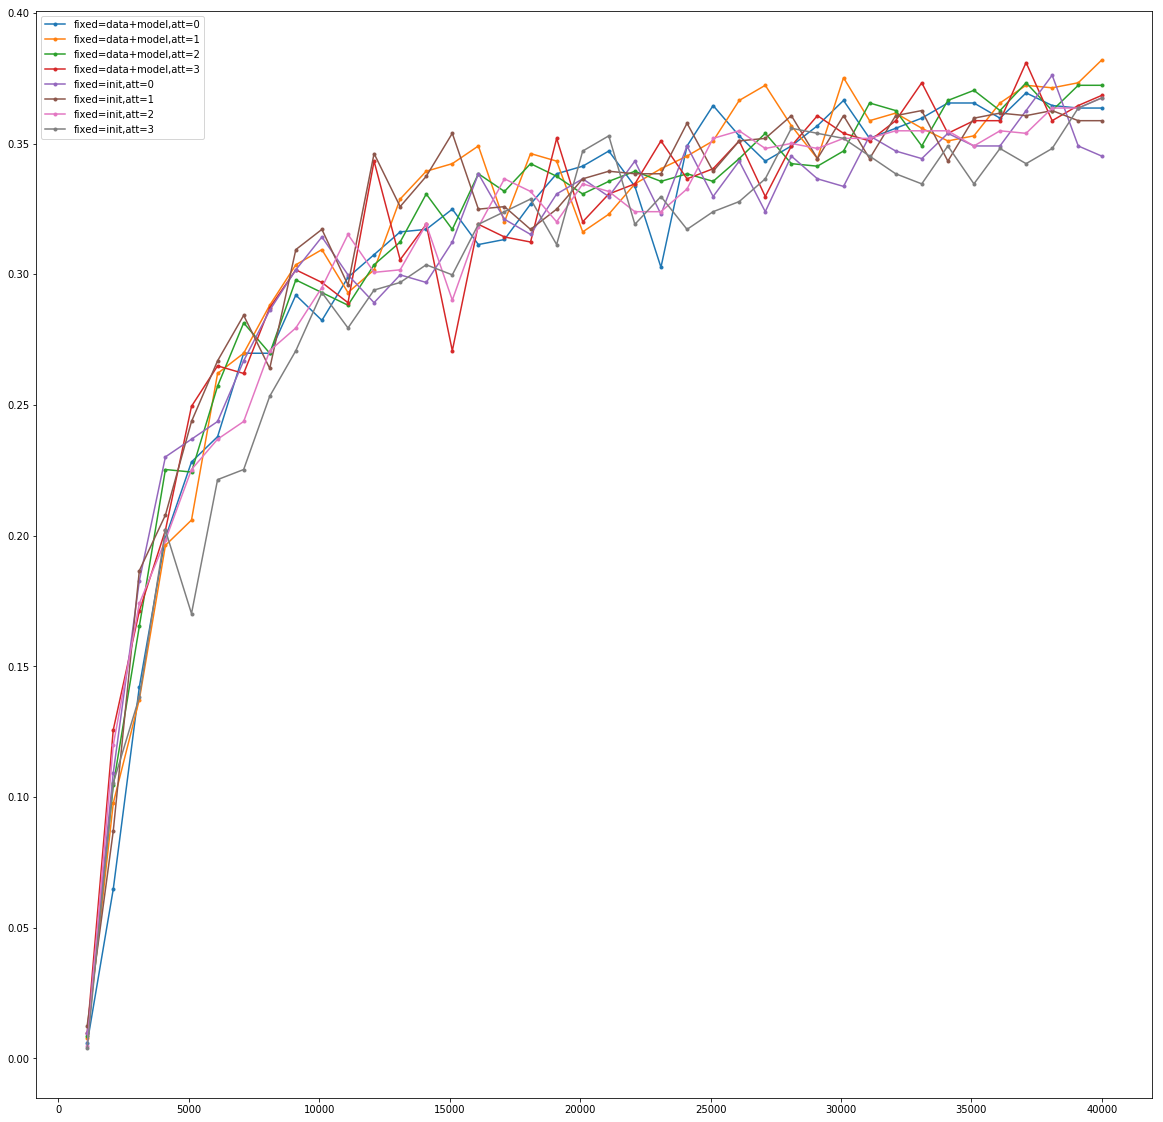

In [15]:
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items()):
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()

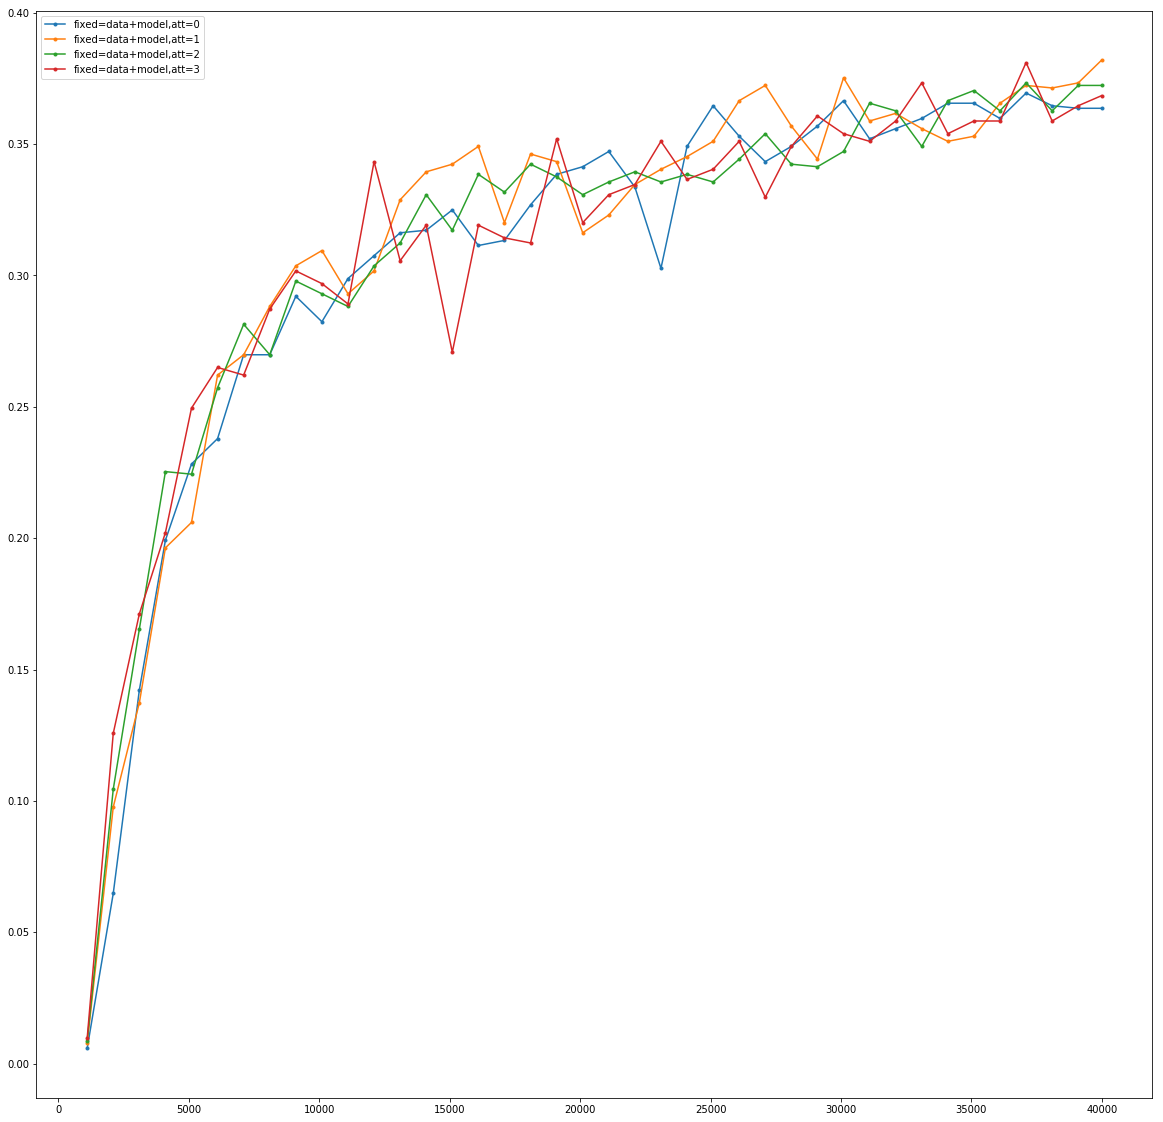

In [16]:
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items())[:4]:
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()

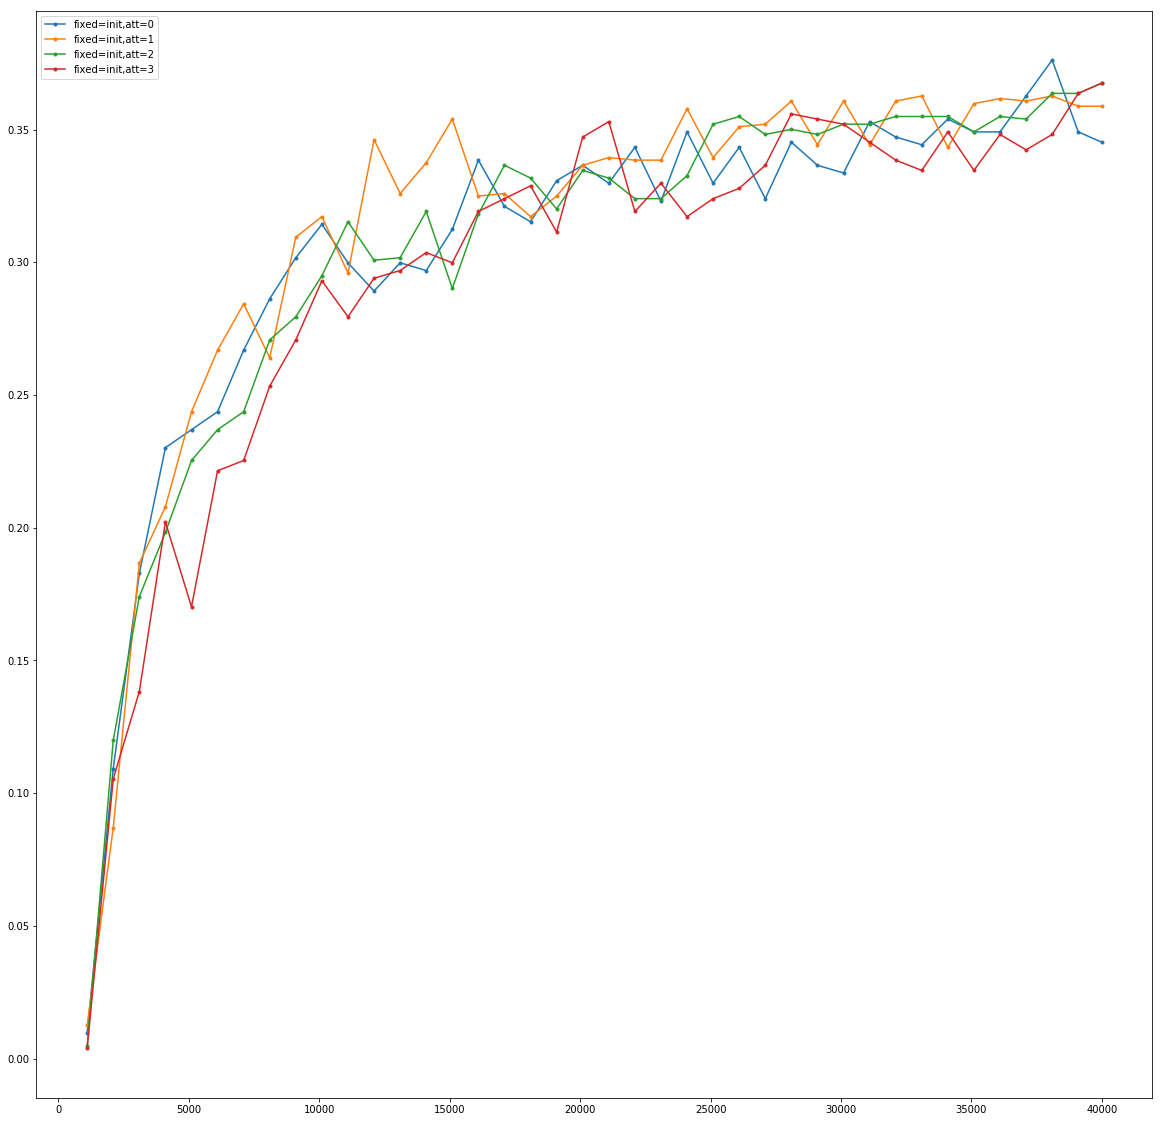

In [17]:
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items())[4:]:
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()

In [20]:
dev = json.load(open('../data/spider-20190205/dev.json'))
def compare(data, left, right):
    both_exact = []
    left_exact = []
    right_exact = []
    neither_exact = []
    for i, (data_item, left_item, right_item) in enumerate(zip(data, left['per_item'], right['per_item'])):
        result = {
            'i': i,
            'db_id': data_item['db_id'],
            'question': data_item['question'],
            'gold': data_item['query'],
            'left': left_item['predicted'],
            'right': right_item['predicted'],
        }
        
        if left_item['exact'] and right_item['exact']:
            both_exact.append(result)
        elif left_item['exact']:
            left_exact.append(result)
        elif right_item['exact']:
            right_exact.append(result)
        else:
            neither_exact.append(result)
    return both_exact, left_exact, right_exact, neither_exact        

In [22]:
both_exact, left_exact, right_exact, neither_exact = compare(
    dev,
    json.load(open('../logdirs/20190428-random/fixed=init,att=0/eval-val-step38100-bs1.jsonl')),
    json.load(open('../logdirs/20190428-random/fixed=init,att=1/eval-val-step33100-bs1.jsonl')))
len(both_exact)/len(dev), len(left_exact)/len(dev), len(right_exact)/len(dev)

(0.27949709864603484, 0.09671179883945841, 0.08317214700193423)

In [23]:
both_exact, left_exact, right_exact, neither_exact = compare(
    dev,
    json.load(open('../logdirs/20190428-random/fixed=data+model,att=0/eval-val-step37100-bs1.jsonl')),
    json.load(open('../logdirs/20190428-random/fixed=data+model,att=1/eval-val-step40000-bs1.jsonl')))
len(both_exact)/len(dev), len(left_exact)/len(dev), len(right_exact)/len(dev)

(0.27852998065764023, 0.09090909090909091, 0.10348162475822051)

In [11]:
accuracy_per_run = collections.defaultdict(dict)
rows = []
for d in sorted(glob.glob('../logdirs/20190428-stability/*')):
    exp_name = os.path.basename(d)
    batch_size, lr, end_lr, att = re.match('bs=([^,]+),lr=([^,]+),end_lr=([^,]+),att=([^,]+)', exp_name).groups()

    eval_paths = glob.glob(os.path.join(d, 'eval-val-step*-bs1.jsonl'))
    all_scores = []
    best = (0, 0)
    for eval_path in eval_paths:
        step = int(re.search('step(\d+)', eval_path).group(1))
        scores = json.load(open(eval_path))
        first_half_exact = compute_accuracy(scores['per_item'][:517])
        second_half_exact = compute_accuracy(scores['per_item'][517:])
        all_scores.append((step, scores['total_scores']['all']['exact'], first_half_exact['all'], second_half_exact['all']))
    
    all_scores.sort(key=operator.itemgetter(0))
    sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
    rows.append((batch_size, lr, end_lr, att, len(eval_paths)) + (sorted_scores[0] if sorted_scores else (-1, -1, -1, -1)))
    accuracy_per_run[exp_name] = {
        'x': [s[0] for s in all_scores],
        'all': [s[1] for s in all_scores],
        '1/2': [s[2] for s in all_scores],
        '2/2': [s[3] for s in all_scores],
    }
    print(d)
    
df = pd.DataFrame(rows, columns=('batch_size', 'lr', 'end_lr', 'att', 'num steps eval', 'step', 'acc', '1/2 acc', '2/2 acc'))

../logdirs/20190428-stability/bs=10,lr=1.0e-03,end_lr=2.5e-04,att=0
../logdirs/20190428-stability/bs=10,lr=1.0e-03,end_lr=5.0e-04,att=0
../logdirs/20190428-stability/bs=10,lr=2.5e-04,end_lr=0e0,att=0
../logdirs/20190428-stability/bs=10,lr=5.0e-04,end_lr=0e0,att=0
../logdirs/20190428-stability/bs=100,lr=1.0e-03,end_lr=0e0,att=0
../logdirs/20190428-stability/bs=100,lr=1.0e-03,end_lr=0e0,att=1
../logdirs/20190428-stability/bs=100,lr=1.0e-03,end_lr=0e0,att=2
../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=0
../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=1
../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=2


In [12]:
df

,batch_size,lr,end_lr,att,num steps eval,step,acc,1/2 acc,2/2 acc
0,10,1.0e-03,2.5e-04,0,40,39100,0.381044,0.400387,0.361702
1,10,1.0e-03,5.0e-04,0,40,25100,0.377176,0.406190,0.348162
2,10,2.5e-04,0e0,0,40,40000,0.395551,0.396518,0.394584
3,10,5.0e-04,0e0,0,40,26100,0.378143,0.377176,0.379110
4,100,1.0e-03,0e0,0,19,19100,0.419729,0.423598,0.415861
5,100,1.0e-03,0e0,1,19,14100,0.407157,0.415861,0.398453
6,100,1.0e-03,0e0,2,18,10100,0.429400,0.425532,0.433269
7,50,1.0e-03,0e0,0,38,26100,0.418762,0.444874,0.392650
8,50,1.0e-03,0e0,1,25,23100,0.400387,0.394584,0.406190
9,50,1.0e-03,0e0,2,33,21100,0.426499,0.441006,0.411992


In [9]:
a = accuracy_per_run['bs=10,lr=2.5e-04,end_lr=0e0,att=0']
list(zip(a['x'], a['all']))

[(1100, 0.0),
 (2100, 0.025145067698259187),
 (3100, 0.097678916827853),
 (4100, 0.18181818181818182),
 (5100, 0.21760154738878143),
 (6100, 0.2504835589941973),
 (7100, 0.2553191489361702),
 (8100, 0.2862669245647969),
 (9100, 0.293036750483559),
 (10100, 0.2978723404255319),
 (11100, 0.32205029013539654),
 (12100, 0.29593810444874274),
 (13100, 0.3181818181818182),
 (14100, 0.327852998065764),
 (15100, 0.31721470019342357),
 (16100, 0.3307543520309478),
 (17100, 0.3452611218568665),
 (18100, 0.35106382978723405),
 (19100, 0.34332688588007737),
 (20100, 0.34235976789168276),
 (21100, 0.3481624758220503),
 (22100, 0.3597678916827853),
 (23100, 0.3655705996131528),
 (24100, 0.3607350096711799),
 (25100, 0.35589941972920697),
 (26100, 0.3597678916827853),
 (27100, 0.3742746615087041),
 (28100, 0.3646034816247582),
 (29100, 0.3655705996131528),
 (30100, 0.3607350096711799),
 (31100, 0.3520309477756286),
 (32100, 0.35106382978723405),
 (33100, 0.3655705996131528),
 (34100, 0.36460348162475

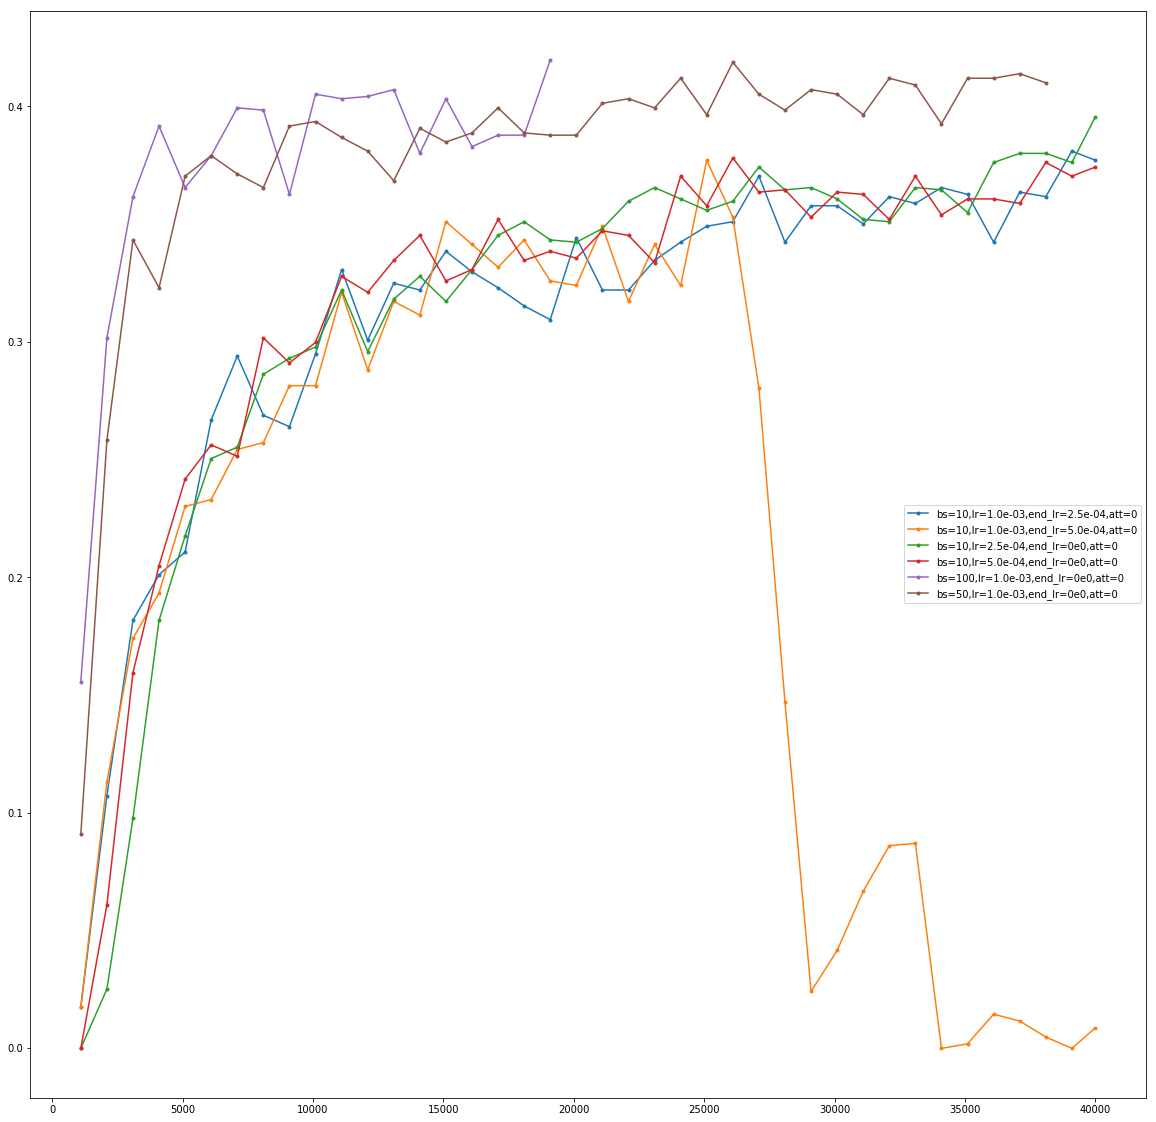

In [8]:
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items()):
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()

In [26]:
both_exact, left_exact, right_exact, neither_exact = compare(
    dev,
    json.load(open('../logdirs/20190428-stability/bs=100,lr=1.0e-03,end_lr=0e0,att=0/eval-val-step10100-bs1.jsonl')),
    json.load(open('../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=0/eval-val-step21100-bs1.jsonl')))
len(both_exact)/len(dev), len(left_exact)/len(dev), len(right_exact)/len(dev)

(0.3181818181818182, 0.08704061895551257, 0.08317214700193423)